In [15]:
import numpy as np

# 假设有三个数组
array1 = np.array([[1, 2, 3], 
                   [4, 5, 6]])  # 形状为 (2, 3)

array2 = np.array([[7,   8,  9], 
                   [10, 11, 12]])  # 形状为 (2, 3)

array3 = np.array([[5,  23,  2], 
                   [13, 11, 32]])  # 形状为 (2, 3)

array = [array1, array2, array3]

In [30]:
array

[array([[1, 2, 3],
        [4, 5, 6]]),
 array([[ 7,  8,  9],
        [10, 11, 12]]),
 array([[ 5, 23,  2],
        [13, 11, 32]])]

In [27]:
for i in range(len(array)):
    if i == 0:
        # 在每个样本上添加一个维度
        array_expanded = np.expand_dims(array[i], axis=0)  # 形状从 (2, 3) 变为 (1, 2, 3)
        continue
    # 垂直拼接两个数组
    array_expanded = np.vstack((array_expanded, np.expand_dims(array[i], axis=0)))

# 输出结果
array_expanded

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]],

       [[ 5, 23,  2],
        [13, 11, 32]]])

In [28]:
array_expanded.shape  # 转好了

(3, 2, 3)

In [2]:
import torch

torch.sort(torch.rand(10))

torch.return_types.sort(
values=tensor([0.0970, 0.2764, 0.4207, 0.4482, 0.4954, 0.7378, 0.8313, 0.8407, 0.9138,
        0.9701]),
indices=tensor([1, 5, 3, 6, 8, 7, 2, 4, 0, 9]))

In [42]:
import random
import matplotlib.pyplot as plt

In [60]:
m_list = []
num_list_2 = []
for m in range(2, 1000):
    num_list = []
    for n in range(2000):
        winner = [0] * 25
        num = 0
        while len(winner) != 1:
            for i in range(len(winner)):
                winner[i] = random.randint(1, m)
            num += 1
            max_value = max(winner)
            for j in winner:
                if j != max_value:
                    winner.remove(j)
            winner = [0] * len(winner)
        num_list.append(num)
    num_list_2.append(sum(num_list) / len(num_list))
    m_list.append(m)

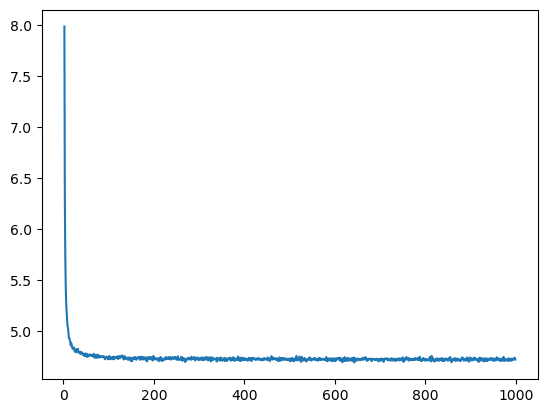

In [61]:
plt.plot(m_list, num_list_2)

In [65]:
sum(num_list_2[-100:]) / 100

4.722665000000001